In [2]:
%matplotlib inline
import numpy as np
import active_subspaces as asub
import matplotlib.pyplot as plt

These functions mimic the interfaces for a simulation quantity of interest and its gradient. The function is a simple quadratic function. 

In [3]:
def quad_fun(x):
    A = np.array([[ 0.2406659045776698, -0.3159904335007421, -0.1746908591702878],
                [-0.3159904335007421,  0.5532215729009683,  0.3777995408101305],
                [-0.1746908591702878,  0.3777995408101305,  0.3161125225213613]])
    x = x.reshape((3,1))
    return 0.5*np.dot(x.T,np.dot(A,x))

def quad_dfun(x):
    A = np.array([[ 0.2406659045776698, -0.3159904335007421, -0.1746908591702878],
                [-0.3159904335007421,  0.5532215729009683,  0.3777995408101305],
                [-0.1746908591702878,  0.3777995408101305,  0.3161125225213613]])
    return np.dot(A,x.reshape((3,1)))

Randomly sample the inputs and compute the gradient for each sample. The **SimulationGradientRunner** is just a for-loop wrapper. 

In [4]:
M, m = 20, 3
X0 = np.random.normal(size=(M, m))
df = asub.utils.simrunners.SimulationGradientRunner(quad_dfun).run(X0)

Use SVD to compute the active and inactive subspaces. Use a bootstrap to study variability in the eigenvalues and the subspace errors. Set the dimension of the active subspace to 1.

In [11]:
ss = asub.subspaces.Subspaces()
ss.compute(df=df,nboot=500)
ss.partition(1)

Plot the eigenvalues and subspace errors with the bootstrap ranges.

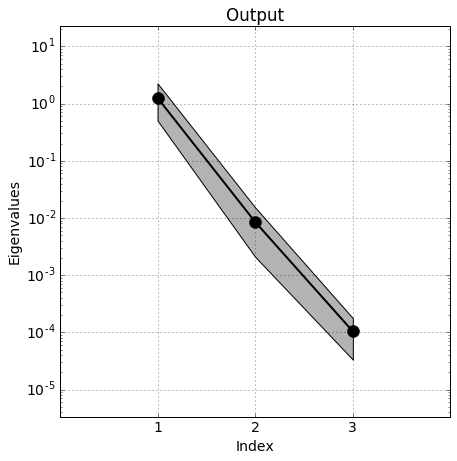

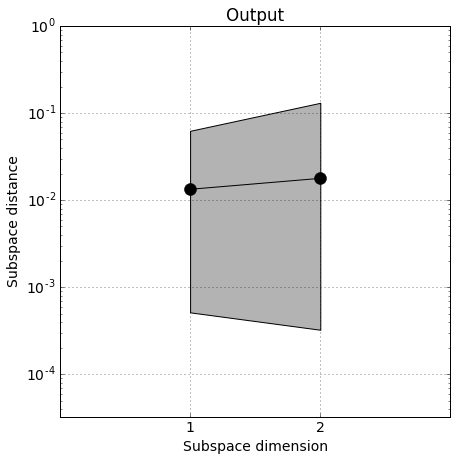

In [12]:
asub.utils.plotters.eigenvalues(ss.eigenvalues, e_br=ss.e_br)
asub.utils.plotters.subspace_errors(ss.sub_br)

Create a domain for the active variable. Create map between the full variables and the active variables. 

In [7]:
avdom = asub.domains.UnboundedActiveVariableDomain(ss)
avmap = asub.domains.UnboundedActiveVariableMap(avdom)

Sample the inputs and evaluate function. **SimulationRunner** is a just a wrapper for a for-loop. Map the sampled inputs to the 1d active variable. Plot the response versus the active variable in the summary plot. 

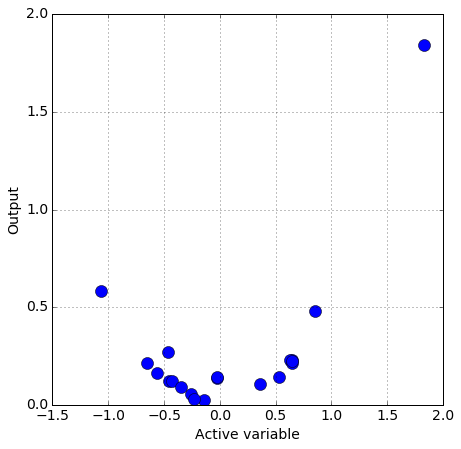

In [8]:
MM = 20
X1 = np.random.normal(size=(MM, m))
fX1 = asub.utils.simrunners.SimulationRunner(quad_fun).run(X1)
Y1 = avmap.forward(X1)[0]
asub.utils.plotters.sufficient_summary(Y1, fX1)

Build a polynomial regression surface of order N=2 with the active variable samples. Evaluate that surface and plot it.

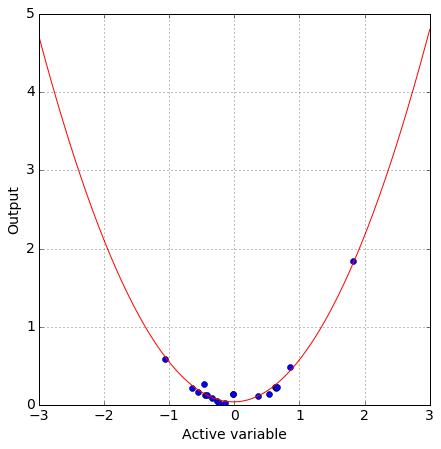

In [9]:
pr = asub.utils.response_surfaces.PolynomialApproximation(N=2)
pr.train(Y1, fX1)
Y2 = np.linspace(-3.0, 3.0, num=200).reshape((200,1))
fY2 = pr.predict(Y2)[0]

plt.figure(figsize=(7,7))
plt.plot(Y1, fX1, 'bo', Y2, fY2, 'r-')
plt.grid(True)
plt.xlabel('Active variable')
plt.ylabel('Output')
plt.show()

Define a response surface on the original variables by combining the active variable forward map and the response surface on the active variables. Estimate the mean of the response surface with Monte Carlo. 

In [10]:
def asub_response_surface(X):
    Y = avmap.forward(X)[0]
    return pr.predict(Y)[0]

X2 = np.random.normal(size=(10000, m))
fX2 = asub_response_surface(X2)
print 'Estimated mean of the response surface: {:6.4f}'.format(np.mean(fX2))

Estimated mean of the response surface: 0.5675
